# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [3]:
video = cv2.VideoCapture("../../data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


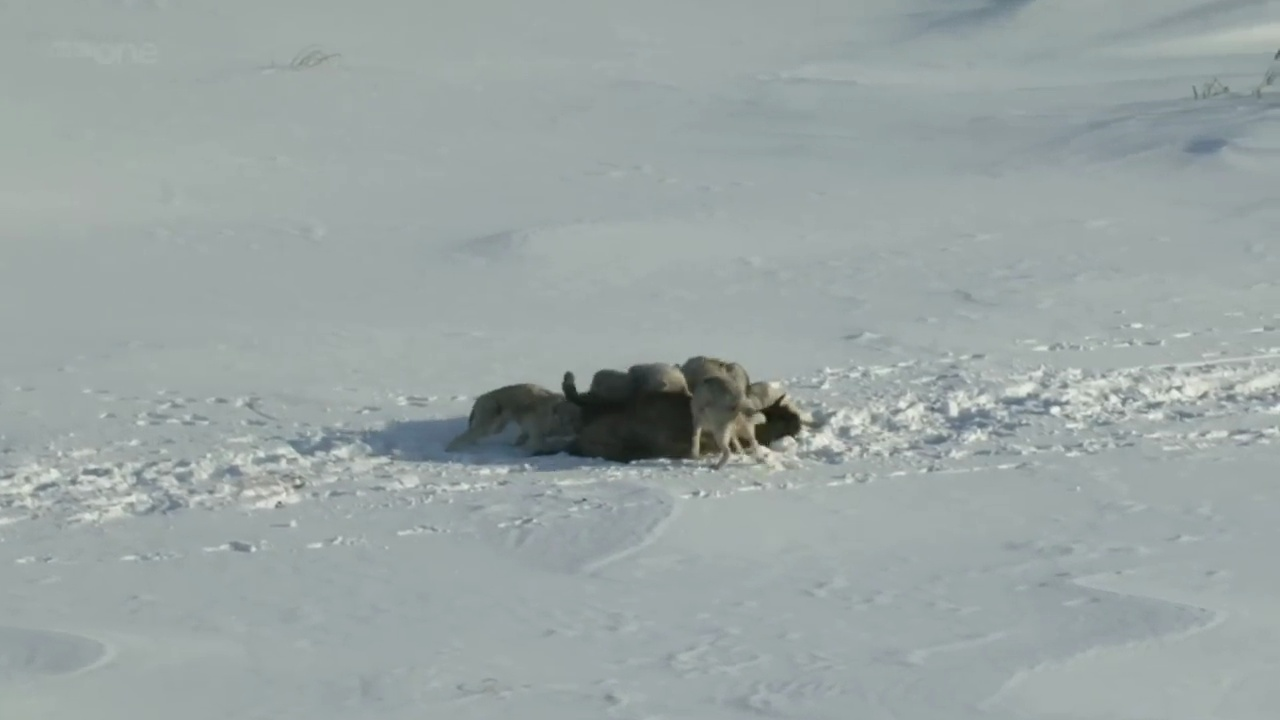

In [4]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Title: "The Struggle for Survival: Bison vs. Wolf Pack in the Snowy Wilderness"

Description: 
Immerse yourself in the raw power of nature with this incredible video capturing an intense encounter between a bison and a relentless wolf pack in a snowy landscape. Witness the sheer strength and survival instincts of the majestic bison as it defends itself against the strategic and coordinated efforts of its determined predators. Each frame of the video presents a breathtaking glimpse into the stark realities of the wild, where every moment is a battle for survival. Don't miss this captivating spectacle that showcases the resilience of wildlife amidst the majestic yet unforgiving winter terrain. Join us in experiencing this unforgettable display of nature's drama.

Keywords:
Nature, Wildlife, Bison, Wolves, Wild Animals, Survival, Snow, Winter, Predator vs Prey, Ecosystem, Natural Behavior, Wildlife Encounter, Animal Battle


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [7]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Here, beneath the crisp, white blanket of snow, a drama unfolds in the freezing heart of winter. A pack of wolves, sinewy and alert, has spotted their quarry—a lone bison, separated from its herd. The wolves, with a keen understanding of teamwork, begin their approach, their paws barely whispering against the snow.

The bison, a hulking bastion of strength, stands its ground. It knows that in this dance of predator and prey, one moment of weakness could spell the end. The wolves circle, darting in with tactical precision, trying to find a chink in the bison's armor. Their breath mists in the frigid air, a silent testament to the life and death struggle unfolding.

As the wolves press their attack, the bison retaliates with a display of raw power, shaking the very ground with defiant fury. It is an epic testament to survival in the desolate, frozen wilderness. Cunning meets might. But even as the bison fights valiantly, outnumbered it begins to tire, and the balance of life leans toward

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [8]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)